# Problem 1

I am going to start by playing around with the data to make sure that I understand its structure.

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!pwd

/content


In [3]:
!ls /content/drive/MyDrive/'Colab Notebooks'/data_AM160_final

z1979.nc  z1980.nc  z1981.nc  z1983.nc	z1985.nc


In [4]:
import xarray as xr

data_root = "/content/drive/MyDrive/Colab Notebooks/data_AM160_final/"
data_1979 = xr.open_dataset(data_root + "z1979.nc")
data_1979

<xarray.Dataset> Size: 383MB
Dimensions:    (longitude: 180, latitude: 91, level: 2, time: 1460)
Coordinates:
  * longitude  (longitude) float32 720B -180.0 -178.0 -176.0 ... 176.0 178.0
  * latitude   (latitude) float32 364B 90.0 88.0 86.0 84.0 ... -86.0 -88.0 -90.0
  * level      (level) int32 8B 50 500
  * time       (time) datetime64[ns] 12kB 1979-01-01 ... 1979-12-31T18:00:00
Data variables:
    z          (time, level, latitude, longitude) float64 383MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-03-22 00:50:56 GMT by grib_to_netcdf-2.24.2: /opt/ecmw...

In [5]:
data_1979["z"].values.shape

(1460, 2, 91, 180)

## Part A

In [6]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 43.4 MB/s eta 0:00:00


I'm plotting the geopotential values at 50 and 500mb levels for 3 different timesteps. I am using cartopy to add natural features to the plots and to help deal with the projections of latitude and longitude values onto a 2D plot.

/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


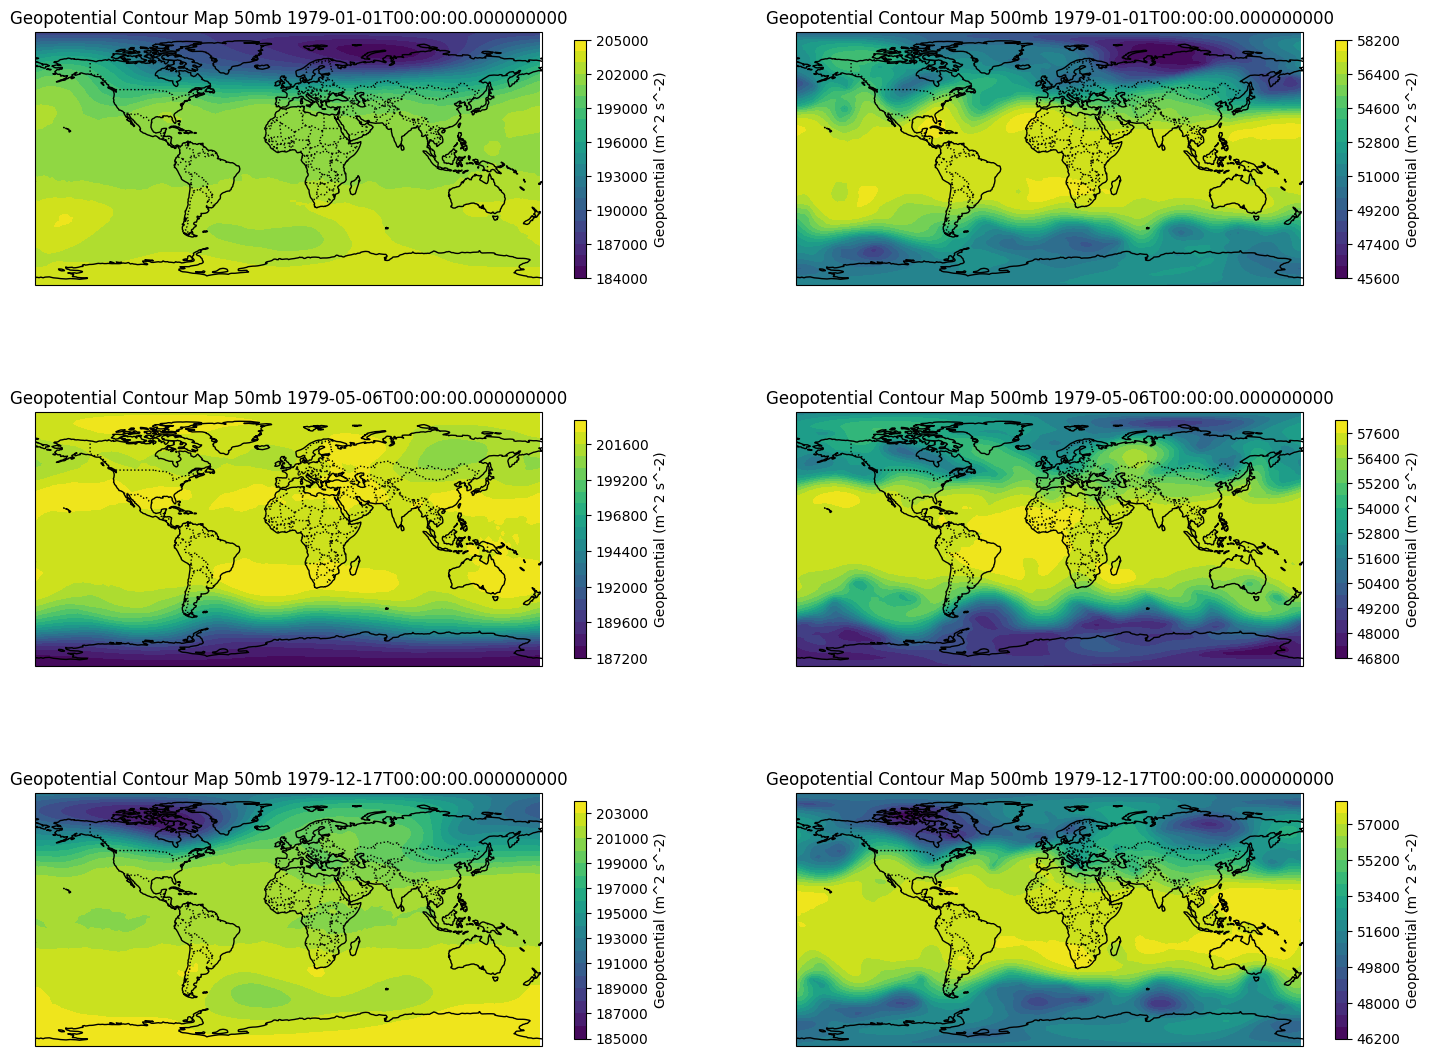

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Assign latitude and longitude values to a variable
lats = data_1979["latitude"].values
lons = data_1979["longitude"].values
times = data_1979["time"].values

f1, ax1 = plt.subplots(3, 2, figsize=(18, 14), subplot_kw={'projection': ccrs.PlateCarree()})
t_array = np.array([0, 500, 1400])

for i in range(3):
  # The first time step of geopotential values for the 50 and 500 levels
  t = t_array[i]
  geo50 = data_1979["z"].values[t, 0]
  geo500 = data_1979["z"].values[t, 1]

  # Set up the map
  #f1, ax1 = plt.subplots(figsize=(10, 7), subplot_kw={'projection': ccrs.PlateCarree()})
  ax1[i, 0].set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())  # Global extent

  # Add natural features
  ax1[i, 0].add_feature(cfeature.COASTLINE)
  ax1[i, 0].add_feature(cfeature.BORDERS, linestyle=':')

  # Create contour plot
  contour50 = ax1[i, 0].contourf(lons, lats, geo50, 20, transform=ccrs.PlateCarree(), cmap='viridis')

  # Add a color bar
  cbar = plt.colorbar(contour50, ax=ax1[i, 0], orientation='vertical', shrink=0.75)
  cbar.set_label('Geopotential (m^2 s^-2)')

  # Add title
  t_str = str(times[t])
  ax1[i, 0].set_title('Geopotential Contour Map 50mb ' + t_str, fontsize=12)


  # Set up the map
  #f1, ax1 = plt.subplots(figsize=(10, 7), subplot_kw={'projection': ccrs.PlateCarree()})
  ax1[i, 1].set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())  # Global extent

  # Add natural features
  ax1[i, 1].add_feature(cfeature.COASTLINE)
  ax1[i, 1].add_feature(cfeature.BORDERS, linestyle=':')

  # Create contour plot
  contour500 = ax1[i, 1].contourf(lons, lats, geo500, 20, transform=ccrs.PlateCarree(), cmap='viridis')

  # Add a color bar
  cbar = plt.colorbar(contour500, ax=ax1[i, 1], orientation='vertical', shrink=0.75)
  cbar.set_label('Geopotential (m^2 s^-2)')

  # Add title
  t_str = str(times[t])
  ax1[i, 1].set_title('Geopotential Contour Map 500mb ' + t_str, fontsize=12)


# Show the plot
plt.show()


## Part B

I'll start by writing a function to corrupt the input data given a desired percentage of sparsity.

In [8]:
def corrupt_data(data, k):
  """Gives corrupted data for either one timestep or for a full year dataset
     depending on the input. k is the percent of corrupted data points.
     Expects a numpy array for the data input."""
  data_c = np.copy(data)
  m, n = 91, 180
  indices = np.random.choice(m*n, size=int(k*m*n), replace=False)

  # Convert the indices into row and column indices in the 2D meshgrid
  lat_indices, lon_indices = np.unravel_index(indices, (m, n))

  # Set the randomly selected points to 0
  if (np.size(data_c.shape) == 3):
    for i in range(2):
      data_c[i][lat_indices, lon_indices] = 0

  elif (np.size(data_c.shape) == 4):
    for i in range(data_c.shape[0]):
      for j in range(2):
        indices = np.random.choice(m*n, size=int(k*m*n), replace=False)
        # Convert the indices into row and column indices in the 2D meshgrid
        lat_indices, lon_indices = np.unravel_index(indices, (m, n))
        data_c[i][j][lat_indices, lon_indices] = 0

  return data_c

In [9]:
data_1979["z"].values.shape

(1460, 2, 91, 180)

In [10]:
t0 = data_1979["z"].values[0]

In [11]:
t0.shape

(2, 91, 180)

In [12]:
t0_c = corrupt_data(t0, 0.3)

In [13]:
t0_c.shape

(2, 91, 180)

Text(0.5, 1.0, 'Geopotential Contour Map 50mb 1979-01-01T00:00:00.000000000')

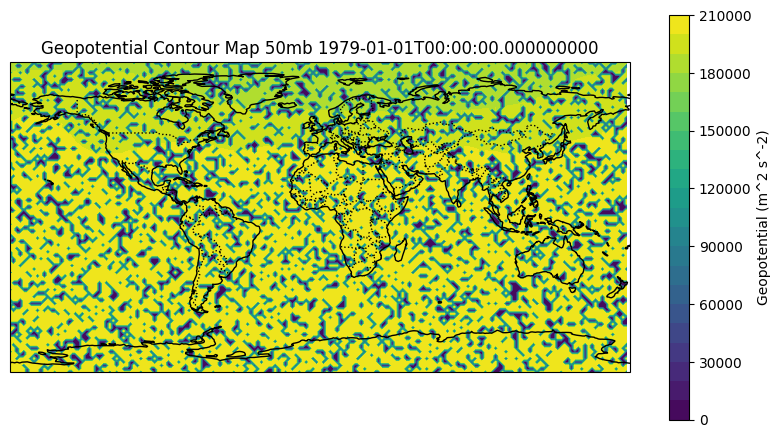

In [14]:
# Set up the map
f2, ax2 = plt.subplots(figsize=(10, 7), subplot_kw={'projection': ccrs.PlateCarree()})
ax2.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())  # Global extent

# Add natural features
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS, linestyle=':')

# Create contour plot
contour_c = ax2.contourf(lons, lats, t0_c[0], 20, transform=ccrs.PlateCarree(), cmap='viridis')

# Add a color bar
cbar = plt.colorbar(contour_c, ax=ax2, orientation='vertical', shrink=0.75)
cbar.set_label('Geopotential (m^2 s^-2)')

# Add title
t_str = str(times[0])
ax2.set_title('Geopotential Contour Map 50mb ' + t_str, fontsize=12)

The plot above demonstrates that the data is correctly corrupted for this time step.

Now I will try corrupting the whole dataset for 1979.

In [15]:
k3 = 0.3
data_1979_c = corrupt_data(data_1979["z"].values, k3)

Text(0.5, 1.0, 'Geopotential Contour Map 500mb 1979-09-08T00:00:00.000000000')

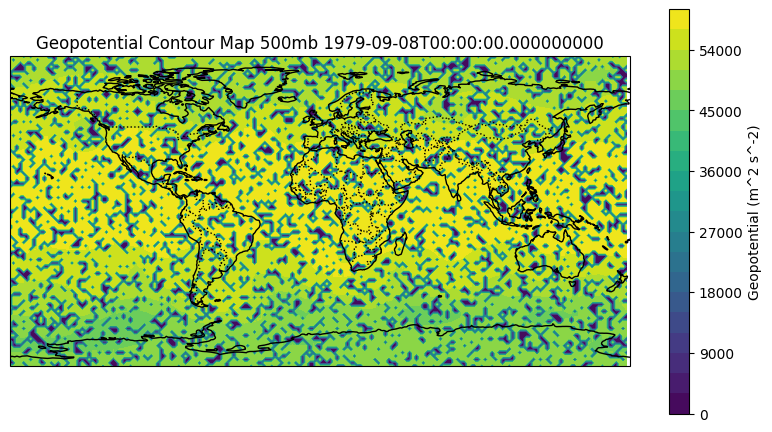

In [16]:
# Set up the map
f3, ax3 = plt.subplots(figsize=(10, 7), subplot_kw={'projection': ccrs.PlateCarree()})
ax3.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())  # Global extent

# Add natural features
ax3.add_feature(cfeature.COASTLINE)
ax3.add_feature(cfeature.BORDERS, linestyle=':')

# Create contour plot
contour_c = ax3.contourf(lons, lats, data_1979_c[1000][1], 20, transform=ccrs.PlateCarree(), cmap='viridis')

# Add a color bar
cbar = plt.colorbar(contour_c, ax=ax3, orientation='vertical', shrink=0.75)
cbar.set_label('Geopotential (m^2 s^-2)')

# Add title
t_str = str(times[1000])
ax3.set_title('Geopotential Contour Map 500mb ' + t_str, fontsize=12)

It looks like that works. Now I will start on the implementation of the ConvVAE model.

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F


kernel_size = 4 # (4, 4) kernel
init_channels = 8 # initial number of filters
image_channels = 2
latent_dim = 16 # latent dimension for sampling

In [18]:
class ConvVAE(nn.Module):
    def __init__(self, image_channels=2, init_channels=32, kernel_size=3, latent_dim=128):
        super(ConvVAE, self).__init__()

        # Encoder
        self.enc1 = nn.Conv2d(image_channels, init_channels, kernel_size=kernel_size, stride=2, padding=1)  # Output: [batch, 32, 64, 128]
        self.enc2 = nn.Conv2d(init_channels, init_channels * 2, kernel_size=kernel_size, stride=2, padding=1)  # Output: [batch, 64, 32, 64]
        self.enc3 = nn.Conv2d(init_channels * 2, init_channels * 4, kernel_size=kernel_size, stride=2, padding=1)  # Output: [batch, 128, 16, 32]
        self.enc4 = nn.Conv2d(init_channels * 4, 256, kernel_size=kernel_size, stride=2, padding=1)  # Output: [batch, 256, 8, 16]

        # Latent space
        self.fc_mu = nn.Linear(256 * 8 * 16, latent_dim)
        self.fc_log_var = nn.Linear(256 * 8 * 16, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 256 * 8 * 16)

        # Decoder
        self.dec1 = nn.ConvTranspose2d(256, init_channels * 4, kernel_size=kernel_size, stride=2, padding=1, output_padding=1)  # Output: [batch, 128, 16, 32]
        self.dec2 = nn.ConvTranspose2d(init_channels * 4, init_channels * 2, kernel_size=kernel_size, stride=2, padding=1, output_padding=1)  # Output: [batch, 64, 32, 64]
        self.dec3 = nn.ConvTranspose2d(init_channels * 2, init_channels, kernel_size=kernel_size, stride=2, padding=1, output_padding=1)  # Output: [batch, 32, 64, 128]
        self.dec4 = nn.ConvTranspose2d(init_channels, image_channels, kernel_size=kernel_size, stride=2, padding=1, output_padding=1)  # Output: [batch, 2, 128, 256]

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encoding
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))

        # Flatten and pass through fully connected layers
        batch_size = x.size(0)
        x = x.view(batch_size, -1)  # Flatten
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)

        # Reparameterization trick
        z = self.reparameterize(mu, log_var)

        # Decoder
        z = self.fc2(z)  # Reshape to match the size after encoding
        z = z.view(-1, 256, 8, 16)  # Reshape to [batch_size, 256, 8, 16]

        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        reconstruction = torch.sigmoid(self.dec4(x))

        return reconstruction, mu, log_var



Setting the shape for the reconstructed image, the output shape of each ConvTranspose2D function is given by:
$$H_{out} = (H_{in} - 1)S - 2P + D(K-1) + P_{out} + 1$$

$$W_{out} = (W_{in} - 1)S - 2P + D(K-1) + P_{out} + 1$$

In [19]:
def computeOutShape(inShape, S, P, Pout, K, D=1):
  return (inShape - 1)*S - 2*P + D*(K-1) + Pout + 1

In [20]:
computeOutShape(32, 2, 1, 1, 3)

64

In [21]:
data_1980 = xr.open_dataset(data_root + "z1980.nc")
data_1981 = xr.open_dataset(data_root + "z1981.nc")
data_1983 = xr.open_dataset(data_root + "z1983.nc")
data_list = [data_1979, data_1980, data_1981, data_1983]
data_list_np = [dataset["z"].values for dataset in data_list]

In [22]:
for dataset in data_list:
  print(dataset["z"].values.shape)

(1460, 2, 91, 180)
(1464, 2, 91, 180)
(1460, 2, 91, 180)
(1460, 2, 91, 180)


In [23]:
X = np.concatenate(data_list_np, axis=0)
X_c = corrupt_data(X, 0.3)

X_min = np.min(X)
X_max = np.max(X)
X_c_min = np.min(X_c)
X_c_max = np.max(X_c)

X_norm = (X - X_min) / (X_max - X_min)
X_c_norm = (X_c - X_c_min) / (X_c_max - X_c_min)

In [24]:
X_tensor = torch.tensor(X_norm, dtype=torch.float32)
X_c_tensor = torch.tensor(X_c_norm, dtype=torch.float32)

# I'll try deleting these variables from memory to free up storage space
del X, X_c, X_norm, X_c_norm

In [25]:
indices = np.random.permutation(np.arange(start=0, stop=X_tensor.size()[0]))

X_shuffled = X_tensor[indices]
X_c_shuffled = X_c_tensor[indices]

del X_tensor, X_c_tensor

In [26]:
X_shuffled.size()

torch.Size([5844, 2, 91, 180])

In [27]:
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

I'm going to try and pad the inputs and outputs to be powers of 2 because I think this will make it easier to match input and output sizes from the model.

In [28]:
# Function to calculate the next power of 2 greater than or equal to the size
def next_power_of_2(x):
    return 2 ** np.ceil(np.log2(x)).astype(int)

# Function to pad an image to the next power of 2 in both dimensions
def pad_to_power_of_2(x):
    batch_size, channels, height, width = x.size()

    # Calculate the next power of 2 for height and width
    target_height = next_power_of_2(height)
    target_width = next_power_of_2(width)

    # Calculate padding needed
    pad_height = target_height - height
    pad_width = target_width - width

    # Padding should be applied symmetrically
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left

    # Apply padding
    padded_x = F.pad(x, (pad_left, pad_right, pad_top, pad_bottom), mode='constant', value=0)

    return padded_x


# Pad the input tensor to the next power of 2
X_shuffled_padded = pad_to_power_of_2(X_shuffled)
X_c_shuffled_padded = pad_to_power_of_2(X_c_shuffled)
print(f"Padded input size: {X_shuffled_padded.size()}")
print(f"Padded input size: {X_c_shuffled_padded.size()}")

Padded input size: torch.Size([5844, 2, 128, 256])
Padded input size: torch.Size([5844, 2, 128, 256])


In [29]:
import torch.optim as optim
# Initialize the network, loss function, and optimizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ConvVAE().to(device)
criterion = nn.BCELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=0.001)
batch_size = 100
trainN = 5844
# Train the network
num_epochs = 50
LOSS = []

for epoch in range(num_epochs):
    for iter in range (0, trainN, batch_size):
        if (iter % 1000 == 0):
         print('iteration number,',iter)
        batch_X_c = X_c_shuffled_padded[iter:iter+batch_size]
        batch_X = X_shuffled_padded[iter:iter+batch_size]
        #print(batch_X.size())
        optimizer.zero_grad()
        outputs = model(batch_X_c.to(device).float())
        reconstruction, mu, log_var = outputs
        #print(reconstruction.size())
        bce_loss = criterion(reconstruction, batch_X.to(device).float())
        loss = final_loss(bce_loss, mu, log_var)
        loss.backward()
        optimizer.step()
    LOSS.append(loss.detach().cpu().numpy())
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


iteration number, 0
iteration number, 1000
iteration number, 2000
iteration number, 3000
iteration number, 4000
iteration number, 5000
Epoch [1/50], Loss: 348729.0000
iteration number, 0
iteration number, 1000
iteration number, 2000
iteration number, 3000
iteration number, 4000
iteration number, 5000
Epoch [2/50], Loss: 327652.2500
iteration number, 0
iteration number, 1000
iteration number, 2000
iteration number, 3000
iteration number, 4000
iteration number, 5000
Epoch [3/50], Loss: 324314.6562
iteration number, 0
iteration number, 1000
iteration number, 2000
iteration number, 3000
iteration number, 4000
iteration number, 5000
Epoch [4/50], Loss: 322957.9375
iteration number, 0
iteration number, 1000
iteration number, 2000
iteration number, 3000
iteration number, 4000
iteration number, 5000
Epoch [5/50], Loss: 322165.6875
iteration number, 0
iteration number, 1000
iteration number, 2000
iteration number, 3000
iteration number, 4000
iteration number, 5000
Epoch [6/50], Loss: 321438.062

Text(0, 0.5, 'Loss')

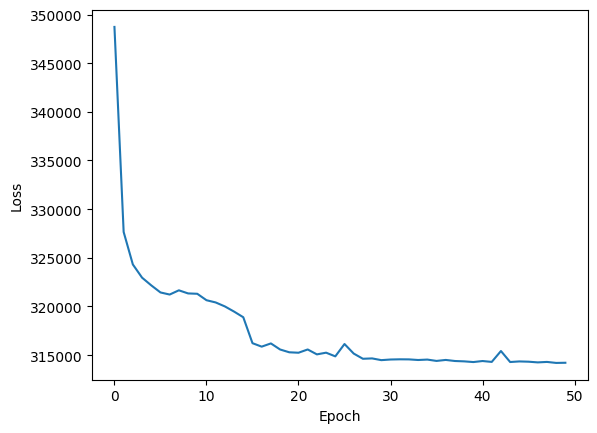

In [30]:
f3, ax3 = plt.subplots()
ax3.plot(LOSS)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss')

Now we'll visualize how well the model works with the test set.

In [31]:
data_test = xr.open_dataset(data_root + "z1985.nc")
data_test_vals = data_test["z"].values

In [32]:
X_test = data_test_vals[0]
X_test.shape

(2, 91, 180)

In [33]:
X_test_c = corrupt_data(X_test, 0.3)

X_test_norm = (X_test - X_min) / (X_max - X_min)
X_test_c_norm = (X_test_c - X_c_min) / (X_c_max - X_c_min)

Text(0.5, 1.0, 'Geopotential Contour Map 500mb Corrupted')

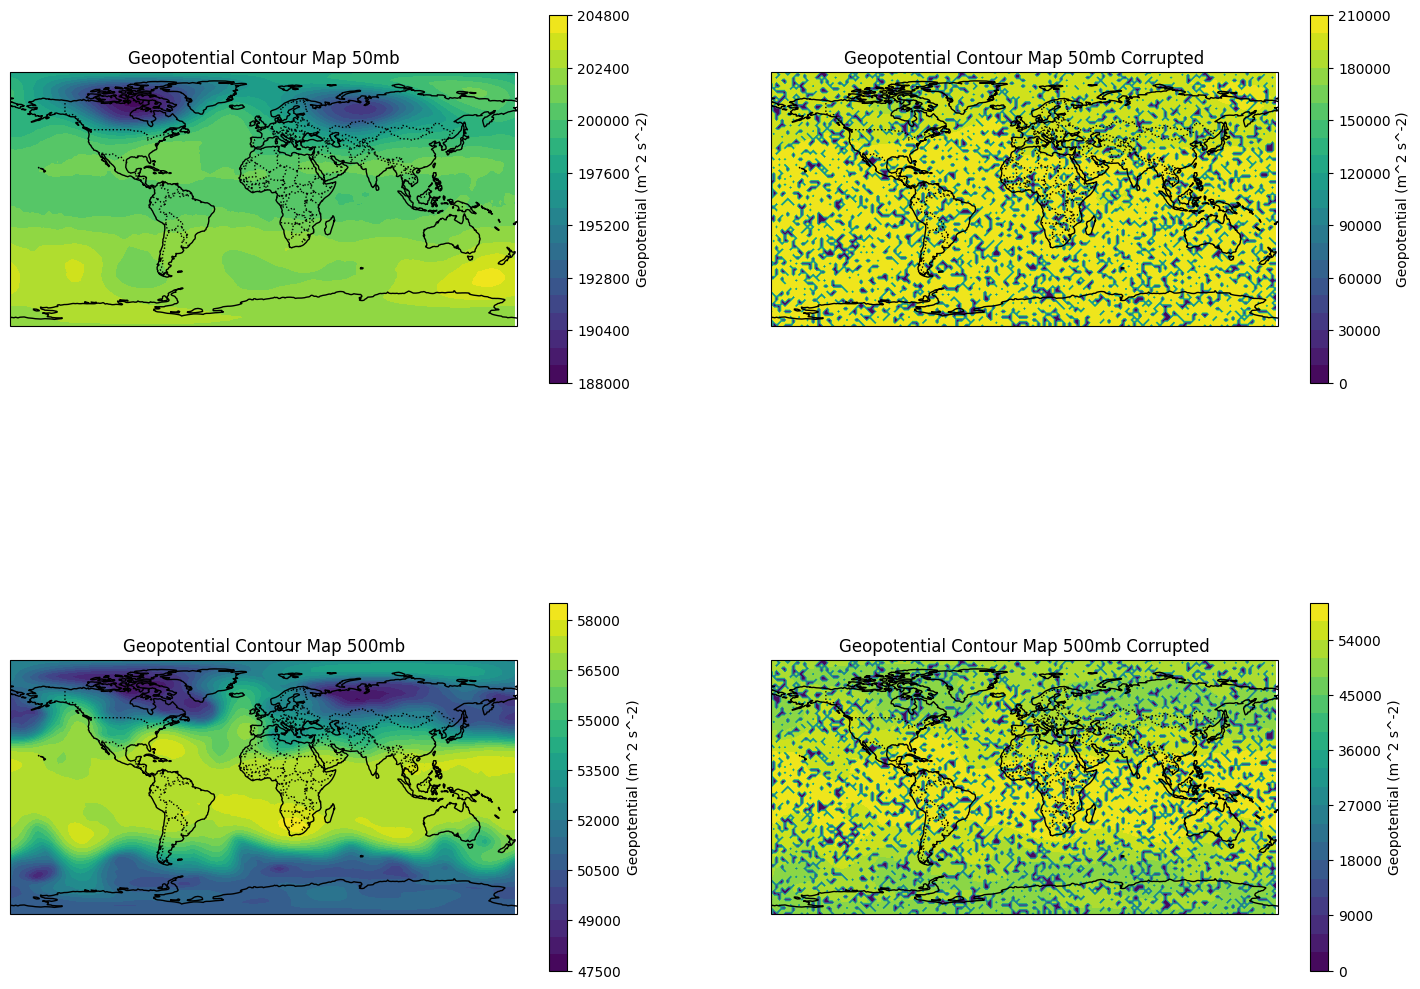

In [34]:
f4, ax4 = plt.subplots(2, 2, figsize=(18, 14), subplot_kw={'projection': ccrs.PlateCarree()})


# Set up the map
#f1, ax1 = plt.subplots(figsize=(10, 7), subplot_kw={'projection': ccrs.PlateCarree()})
ax4[0, 0].set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())  # Global extent

# Add natural features
ax4[0, 0].add_feature(cfeature.COASTLINE)
ax4[0, 0].add_feature(cfeature.BORDERS, linestyle=':')

# Create contour plot
contour50 = ax4[0, 0].contourf(lons, lats, X_test[0], 20, transform=ccrs.PlateCarree(), cmap='viridis')

# Add a color bar
cbar = plt.colorbar(contour50, ax=ax4[0, 0], orientation='vertical', shrink=0.75)
cbar.set_label('Geopotential (m^2 s^-2)')

# Add title
ax4[0, 0].set_title('Geopotential Contour Map 50mb', fontsize=12)

# Set up the map
#f1, ax1 = plt.subplots(figsize=(10, 7), subplot_kw={'projection': ccrs.PlateCarree()})
ax4[0, 1].set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())  # Global extent

# Add natural features
ax4[0, 1].add_feature(cfeature.COASTLINE)
ax4[0, 1].add_feature(cfeature.BORDERS, linestyle=':')

# Create contour plot
contour50_c = ax4[0, 1].contourf(lons, lats, X_test_c[0], 20, transform=ccrs.PlateCarree(), cmap='viridis')

# Add a color bar
cbar = plt.colorbar(contour50_c, ax=ax4[0, 1], orientation='vertical', shrink=0.75)
cbar.set_label('Geopotential (m^2 s^-2)')

# Add title
ax4[0, 1].set_title('Geopotential Contour Map 50mb Corrupted', fontsize=12)


# Set up the map
#f1, ax1 = plt.subplots(figsize=(10, 7), subplot_kw={'projection': ccrs.PlateCarree()})
ax4[1, 0].set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())  # Global extent

# Add natural features
ax4[1, 0].add_feature(cfeature.COASTLINE)
ax4[1, 0].add_feature(cfeature.BORDERS, linestyle=':')

# Create contour plot
contour500 = ax4[1, 0].contourf(lons, lats, X_test[1], 20, transform=ccrs.PlateCarree(), cmap='viridis')

# Add a color bar
cbar = plt.colorbar(contour500, ax=ax4[1, 0], orientation='vertical', shrink=0.75)
cbar.set_label('Geopotential (m^2 s^-2)')

# Add title
ax4[1, 0].set_title('Geopotential Contour Map 500mb', fontsize=12)

# Set up the map
#f1, ax1 = plt.subplots(figsize=(10, 7), subplot_kw={'projection': ccrs.PlateCarree()})
ax4[1, 1].set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())  # Global extent

# Add natural features
ax4[1, 1].add_feature(cfeature.COASTLINE)
ax4[1, 1].add_feature(cfeature.BORDERS, linestyle=':')

# Create contour plot
contour500_c = ax4[1, 1].contourf(lons, lats, X_test_c[1], 20, transform=ccrs.PlateCarree(), cmap='viridis')

# Add a color bar
cbar = plt.colorbar(contour500_c, ax=ax4[1, 1], orientation='vertical', shrink=0.75)
cbar.set_label('Geopotential (m^2 s^-2)')

# Add title
ax4[1, 1].set_title('Geopotential Contour Map 500mb Corrupted', fontsize=12)

In [35]:
X_test_tensor = torch.tensor(X_test_norm, dtype=torch.float32).view(-1, 2, 91, 180)
X_test_c_tensor = torch.tensor(X_test_c_norm, dtype=torch.float32).view(-1, 2, 91, 180)

X_test_padded = pad_to_power_of_2(X_test_tensor)
X_test_c_padded = pad_to_power_of_2(X_test_c_tensor)
print(f"Padded input size: {X_test_padded.size()}")
print(f"Padded input size: {X_test_c_padded.size()}")

Padded input size: torch.Size([1, 2, 128, 256])
Padded input size: torch.Size([1, 2, 128, 256])


In [36]:
test_rec, test_mu, test_log_var = model(X_test_c_padded.to(device).float())

In [37]:
test_rec.size()

torch.Size([1, 2, 128, 256])

In [38]:
# Example of how to undo padding based on the values from the padding step
def undo_padding(padded_image, pad_top, pad_bottom, pad_left, pad_right):
    # Slice the tensor to remove padding
    return padded_image[:, :, pad_top: -pad_bottom, pad_left: -pad_right]


In [39]:
# The amount of padding applied during the padding step
target_height = 128
target_width = 256
pad_height = target_height - 91  # Height padding
pad_width = target_width - 180  # Width padding

pad_top = pad_height // 2  # Padding at the top
pad_bottom = pad_height - pad_top  # Padding at the bottom
pad_left = pad_width // 2  # Padding at the left
pad_right = pad_width - pad_left  # Padding at the right


test_rec_no_padding = undo_padding(test_rec, pad_top, pad_bottom, pad_left, pad_right)

test_rec_np = test_rec_no_padding.cpu().detach().numpy()

# Check the size to confirm it's back to the original shape
print(f"Reconstructed image size after undoing padding: {test_rec_np.shape}")

Reconstructed image size after undoing padding: (1, 2, 91, 180)


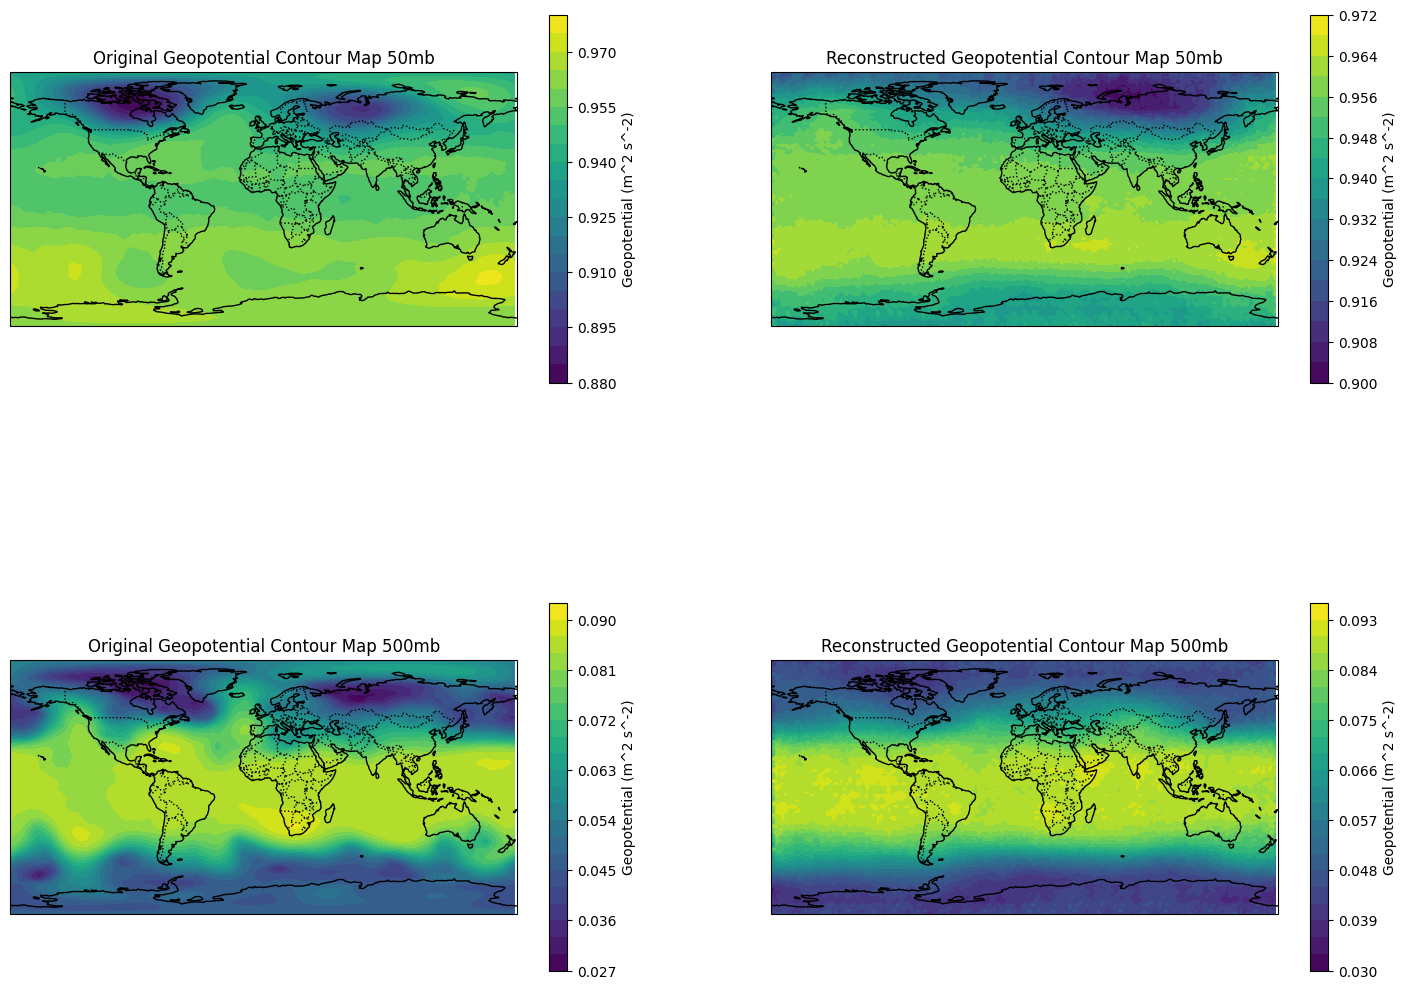

In [40]:
f5, ax5 = plt.subplots(2, 2, figsize=(18, 14), subplot_kw={'projection': ccrs.PlateCarree()})


# Set up the map
#f1, ax1 = plt.subplots(figsize=(10, 7), subplot_kw={'projection': ccrs.PlateCarree()})
ax5[0, 0].set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())  # Global extent

# Add natural features
ax5[0, 0].add_feature(cfeature.COASTLINE)
ax5[0, 0].add_feature(cfeature.BORDERS, linestyle=':')

# Create contour plot
contour50 = ax5[0, 0].contourf(lons, lats, X_test_norm[0], 20, transform=ccrs.PlateCarree(), cmap='viridis')

# Add a color bar
cbar = plt.colorbar(contour50, ax=ax5[0, 0], orientation='vertical', shrink=0.75)
cbar.set_label('Geopotential (m^2 s^-2)')

# Add title
ax5[0, 0].set_title('Original Geopotential Contour Map 50mb', fontsize=12)

# Set up the map
#f1, ax1 = plt.subplots(figsize=(10, 7), subplot_kw={'projection': ccrs.PlateCarree()})
ax5[0, 1].set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())  # Global extent

# Add natural features
ax5[0, 1].add_feature(cfeature.COASTLINE)
ax5[0, 1].add_feature(cfeature.BORDERS, linestyle=':')

# Create contour plot
contour50_rec = ax5[0, 1].contourf(lons, lats, test_rec_np[0][0], 20, transform=ccrs.PlateCarree(), cmap='viridis')

# Add a color bar
cbar = plt.colorbar(contour50_rec, ax=ax5[0, 1], orientation='vertical', shrink=0.75)
cbar.set_label('Geopotential (m^2 s^-2)')

# Add title
ax5[0, 1].set_title('Reconstructed Geopotential Contour Map 50mb', fontsize=12)


# Set up the map
#f1, ax1 = plt.subplots(figsize=(10, 7), subplot_kw={'projection': ccrs.PlateCarree()})
ax5[1, 0].set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())  # Global extent

# Add natural features
ax5[1, 0].add_feature(cfeature.COASTLINE)
ax5[1, 0].add_feature(cfeature.BORDERS, linestyle=':')

# Create contour plot
contour50 = ax5[1, 0].contourf(lons, lats, X_test_norm[1], 20, transform=ccrs.PlateCarree(), cmap='viridis')

# Add a color bar
cbar = plt.colorbar(contour50, ax=ax5[1, 0], orientation='vertical', shrink=0.75)
cbar.set_label('Geopotential (m^2 s^-2)')

# Add title
ax5[1, 0].set_title('Original Geopotential Contour Map 500mb', fontsize=12)

# Set up the map
#f1, ax1 = plt.subplots(figsize=(10, 7), subplot_kw={'projection': ccrs.PlateCarree()})
ax5[1, 1].set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())  # Global extent

# Add natural features
ax5[1, 1].add_feature(cfeature.COASTLINE)
ax5[1, 1].add_feature(cfeature.BORDERS, linestyle=':')

# Create contour plot
contour50_rec = ax5[1, 1].contourf(lons, lats, test_rec_np[0][1], 20, transform=ccrs.PlateCarree(), cmap='viridis')

# Add a color bar
cbar = plt.colorbar(contour50_rec, ax=ax5[1, 1], orientation='vertical', shrink=0.75)
cbar.set_label('Geopotential (m^2 s^-2)')

# Add title
ax5[1, 1].set_title('Reconstructed Geopotential Contour Map 500mb', fontsize=12)

f5.savefig("/content/drive/MyDrive/Colab Notebooks/reconstructed_maps.png")

Pretty good. Looks like it misses the finer scale features but it gets the large scale spatial variation of geopotential. Perhaps this could be fixed with more training or a modified architecture. I will try generating another output for the same input to prove that the model is generative and doesn't give the same output again.

In [41]:
test_rec2, _, _ = model(X_test_c_padded.to(device).float())

In [42]:
test_rec_no_padding2 = undo_padding(test_rec2, pad_top, pad_bottom, pad_left, pad_right)

test_rec_np2 = test_rec_no_padding2.cpu().detach().numpy()

# Check the size to confirm it's back to the original shape
print(f"Reconstructed image size after undoing padding: {test_rec_np2.shape}")

Reconstructed image size after undoing padding: (1, 2, 91, 180)


Text(0.5, 1.0, 'Reconstructed Geopotential Contour Map 500mb')

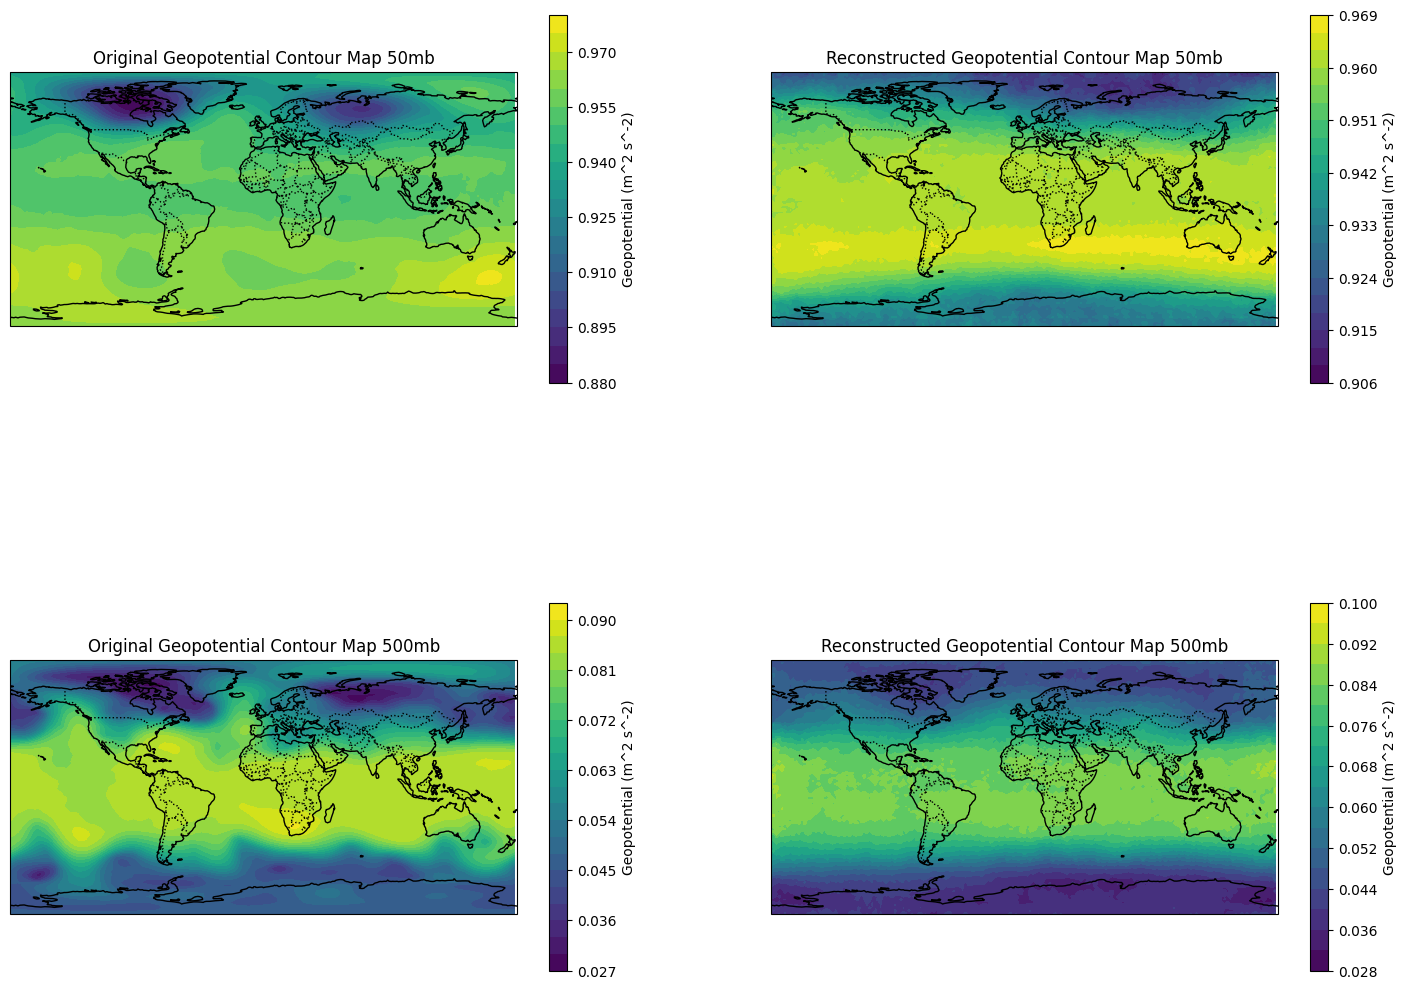

In [43]:
f6, ax6 = plt.subplots(2, 2, figsize=(18, 14), subplot_kw={'projection': ccrs.PlateCarree()})

# Set up the map
ax6[0, 0].set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())  # Global extent

# Add natural features
ax6[0, 0].add_feature(cfeature.COASTLINE)
ax6[0, 0].add_feature(cfeature.BORDERS, linestyle=':')

# Create contour plot
contour50 = ax6[0, 0].contourf(lons, lats, X_test_norm[0], 20, transform=ccrs.PlateCarree(), cmap='viridis')

# Add a color bar
cbar = plt.colorbar(contour50, ax=ax6[0, 0], orientation='vertical', shrink=0.75)
cbar.set_label('Geopotential (m^2 s^-2)')

# Add title
ax6[0, 0].set_title('Original Geopotential Contour Map 50mb', fontsize=12)

# Set up the map
ax6[0, 1].set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())  # Global extent

# Add natural features
ax6[0, 1].add_feature(cfeature.COASTLINE)
ax6[0, 1].add_feature(cfeature.BORDERS, linestyle=':')

# Create contour plot
contour50_rec = ax6[0, 1].contourf(lons, lats, test_rec_np2[0][0], 20, transform=ccrs.PlateCarree(), cmap='viridis')

# Add a color bar
cbar = plt.colorbar(contour50_rec, ax=ax6[0, 1], orientation='vertical', shrink=0.75)
cbar.set_label('Geopotential (m^2 s^-2)')

# Add title
ax6[0, 1].set_title('Reconstructed Geopotential Contour Map 50mb', fontsize=12)

# Set up the map
ax6[1, 0].set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())  # Global extent

# Add natural features
ax6[1, 0].add_feature(cfeature.COASTLINE)
ax6[1, 0].add_feature(cfeature.BORDERS, linestyle=':')

# Create contour plot
contour50 = ax6[1, 0].contourf(lons, lats, X_test_norm[1], 20, transform=ccrs.PlateCarree(), cmap='viridis')

# Add a color bar
cbar = plt.colorbar(contour50, ax=ax6[1, 0], orientation='vertical', shrink=0.75)
cbar.set_label('Geopotential (m^2 s^-2)')

# Add title
ax6[1, 0].set_title('Original Geopotential Contour Map 500mb', fontsize=12)

# Set up the map
ax6[1, 1].set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())  # Global extent

# Add natural features
ax6[1, 1].add_feature(cfeature.COASTLINE)
ax6[1, 1].add_feature(cfeature.BORDERS, linestyle=':')

# Create contour plot
contour50_rec = ax6[1, 1].contourf(lons, lats, test_rec_np2[0][1], 20, transform=ccrs.PlateCarree(), cmap='viridis')

# Add a color bar
cbar = plt.colorbar(contour50_rec, ax=ax6[1, 1], orientation='vertical', shrink=0.75)
cbar.set_label('Geopotential (m^2 s^-2)')

# Add title
ax6[1, 1].set_title('Reconstructed Geopotential Contour Map 500mb', fontsize=12)


It might not be super obvious if these outputs are different from the plots, so I will compute the difference and show that it's not zero.

In [46]:
np.sum((test_rec_np - test_rec_np2)**2)

np.float32(0.71774626)